In [ ]:
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import random

In [ ]:
def define_discriminator():
  # desired input
  desired_input = keras.Input(shape=(26,))
  embedded_desired_input = layers.Embedding(2, 50)(desired_input)
  matched_desired_input = layers.Dense(12)(embedded_desired_input)
  matched_desired_input = layers.Reshape((12, 26))(matched_desired_input)

  input_to_check = keras.Input(shape=(12, 1))

  merged_input = layers.concatenate([matched_desired_input, input_to_check])

  input_6 = layers.Conv1D(128, 3, 2, padding='same')(merged_input)
  input_6 = layers.LeakyReLU(0.2)(input_6)
  input_3 = layers.Conv1D(128, 3, 2, padding='same')(input_6)
  input_3 = layers.LeakyReLU(0.2)(input_3)
  flattened = layers.Flatten()(input_3)
  dropped_out = layers.Dropout(0.4)(flattened)
  out_layer = layers.Dense(1, 'sigmoid')(dropped_out)
  model = keras.Model([desired_input, input_to_check], out_layer)
  optimizer = keras.optimizers.Adam(0.00002, 0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

# keras.utils.plot_model(define_discriminator(), 'my_first_model.png', show_shapes=True)
# model = define_discriminator()
# model([tf.random.uniform(shape=[1,26], maxval=2)-1, tf.random.uniform(shape=[1,12], maxval=2)-1], training=False)

In [ ]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='same'):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = layers.Lambda(lambda x: keras.backend.expand_dims(x, axis=2))(input_tensor)
    x = layers.Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
    x = layers.Lambda(lambda x: keras.backend.squeeze(x, axis=2))(x)
    return x

def define_generator(latent_dim):
  # desired input
  desired_input = keras.Input(shape=(26,))
  reshaped_desired_input = layers.Embedding(2, 50)(desired_input)
  matched_desired_input = layers.Dense(3)(reshaped_desired_input)
  matched_desired_input = layers.Reshape((3, 26))(matched_desired_input)

  noise_input = keras.Input(shape=(latent_dim,))
  matched_noise_input = layers.Dense(128*3)(noise_input)
  matched_noise_input = layers.LeakyReLU(0.2)(matched_noise_input)
  matched_noise_input = layers.Reshape((3, 128))(matched_noise_input)

  merged_input = layers.concatenate([matched_desired_input, matched_noise_input])
  output_6 = Conv1DTranspose(merged_input, 128, 4)
  output_6 = layers.LeakyReLU(0.2)(output_6)
  output_12 = Conv1DTranspose(output_6, 1, 4)
  output_12 = layers.LeakyReLU(0.2)(output_12)
  out_layer = layers.Conv1D(1, 12, activation='sigmoid', padding='same')(output_12)
  model = keras.Model([desired_input, noise_input], out_layer)
  return model

# keras.utils.plot_model(define_generator(100), 'my_first_model.png', show_shapes=True)
# model = define_generator(100)
# model([tf.random.uniform(shape=[1,26], maxval=2)-1, tf.random.normal(shape=[1,100])], training=False)
# model.predict([tf.random.uniform(shape=[1,26], maxval=2), tf.random.normal(shape=[1,100])])

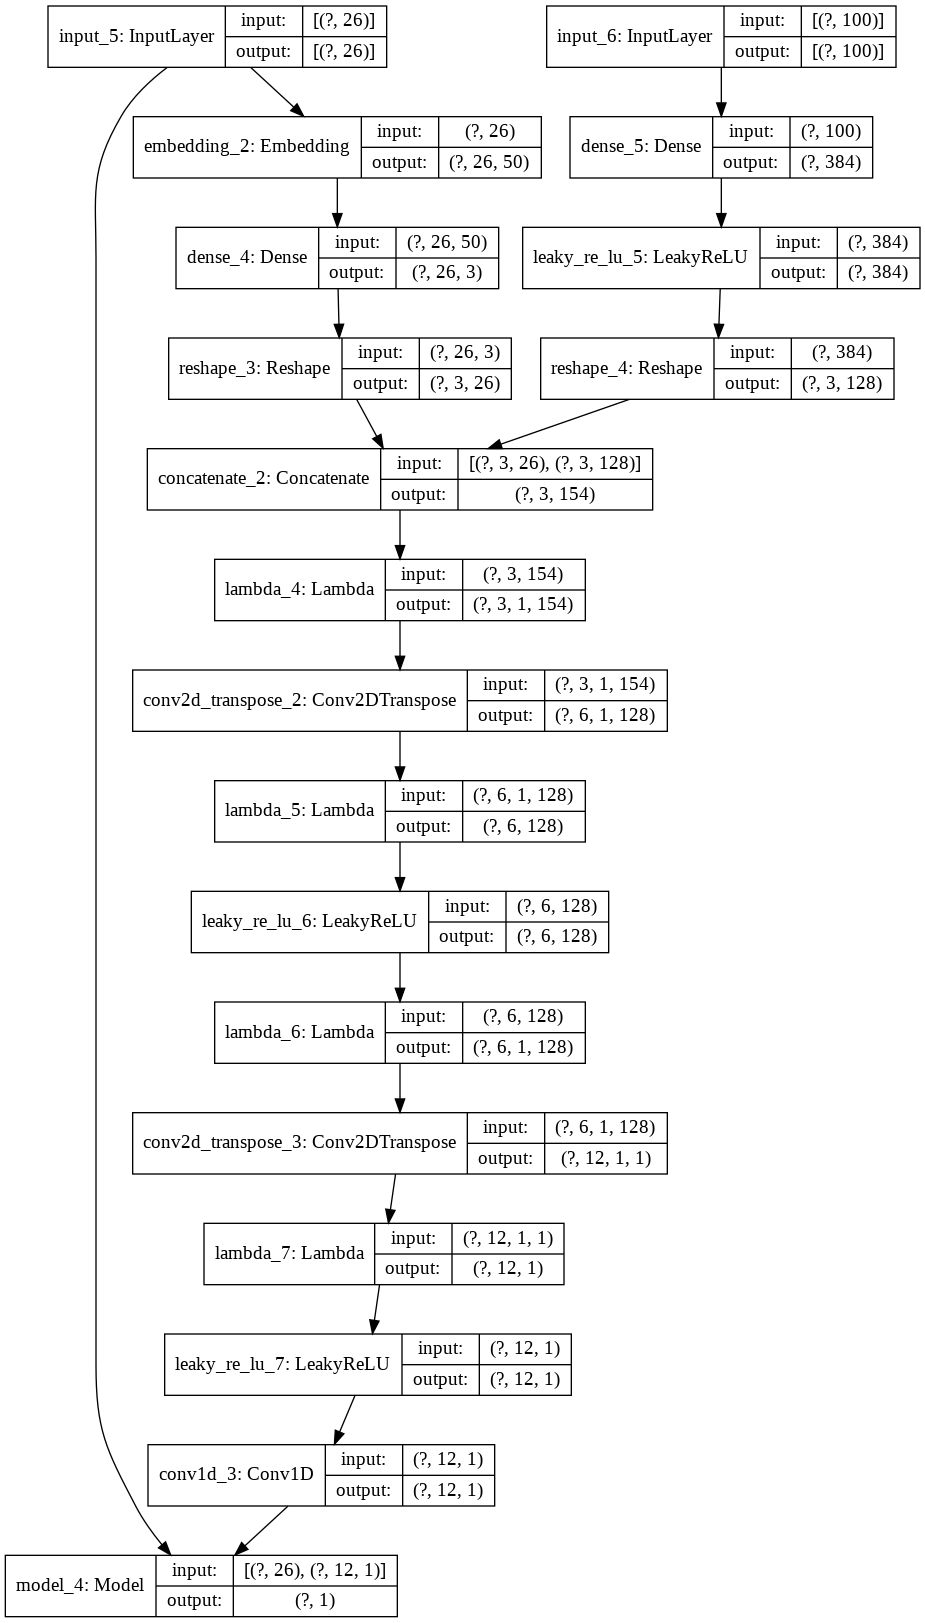

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  gen_desired_input, gen_noise = g_model.input
  gen_output = g_model.output
  gan_output = d_model([gen_desired_input, gen_output])
  model = keras.Model([gen_noise, gen_desired_input], gan_output)
  optimizer = keras.optimizers.Adam(0.02, 0.5)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model
keras.utils.plot_model(define_gan(define_generator(100), define_discriminator()), 'my_first_model.png', show_shapes=True)

In [ ]:
def load_real_samples():
  examples = np.genfromtxt('all_examples.csv', delimiter=',')
  X = tf.convert_to_tensor(examples[:, 26:])
  return [X, tf.expand_dims(tf.convert_to_tensor(examples[:, :26]), axis=-1)]

def generate_real_samples(dataset, n_samples, batch_number, max_batch):
  input, output = dataset
  ix = np.random.randint(0, input.shape[0], n_samples)
  X, out = input[ix], output[ix]
  out = out + tf.random.normal(out.shape, stddev=0.25*(max_batch*2 - batch_number)/max_batch) - 0.3
  y = np.ones((n_samples, 1))
  return [X, out], y

def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  scales = np.asarray([[0, 2, 4, 5, 7, 9, 11], # ionian
                      #  [0, 2, 4, 6, 7, 9, 11], # lydian
                      #  [0, 2, 4, 5, 7, 9, 10], # mixolydian
                      #  [0, 2, 3, 5, 7, 9, 10], # dorian
                      #  [0, 1, 3, 5, 7, 8, 10], # phyrgian
                      #  [0, 2, 3, 5, 7, 8, 10], # aeolian
                       [0, 2, 3, 5, 7, 8, 11]]) # harmonic minor
  selected_scales = np.random.randint(0, len(scales), n_samples)
  selected_roots = np.random.randint(0, 7, n_samples)
  selected_thirds = 2*(np.random.randint(2, 5, n_samples)+1)
  selected_thirds = [np.arange(0, i, 2) for i in selected_thirds]
  selected_modes = np.zeros((n_samples, 2))
  selected_melody = np.zeros((n_samples, 12))
  selected_chords = np.zeros((n_samples, 12))
  for i in range(n_samples):
    chord_degrees = (selected_roots[i]+selected_thirds[i]) % 7
    chord_tones = scales[selected_scales[i]][chord_degrees]
    selected_chords[i][chord_tones] = 1

    melody_degrees = np.random.choice(7, random.randrange(1, 4), replace=False)
    melody_tones = scales[selected_scales[i]][melody_degrees]
    selected_melody[i][melody_tones] = 1
    # selected_melody[i][chord_tones[np.random.choice(len(chord_tones), random.randrange(1, len(chord_tones)), replace=False)]] = 1

    selected_modes[i][int(selected_scales[i] > 2)] = 1
  fabricated_input = np.concatenate([selected_modes, selected_chords, selected_melody], axis=1)
  return [z_input, fabricated_input]

def generate_fake_samples(generator, latent_dim, n_samples):
  z_input, fabricated_input = generate_latent_points(latent_dim, n_samples)
  generated = generator.predict([fabricated_input, z_input])
  y = np.zeros((n_samples, 1))
  return [generated, fabricated_input], y

# generate_fake_samples(define_generator(100), 100, 10)

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      [result_real, input_real], y_real = generate_real_samples(dataset, half_batch, i*bat_per_epo + j, n_epochs*bat_per_epo)
      d_loss1, d_acc1 = d_model.train_on_batch([result_real, input_real], y_real)
      [result_fake, input_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, d_acc2 = d_model.train_on_batch([input_fake, result_fake], y_fake)

      # for k in range(4):
      #   [z_input, fabricated_input] = generate_latent_points(latent_dim, n_batch)
      #   y_gan = np.ones((n_batch, 1))
      #   gan_model.train_on_batch([z_input, fabricated_input], y_gan)
      
      [z_input, fabricated_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, fabricated_input], y_gan)
      print('>%d, %d/%d, dloss1=%.3f, dacc1=%.3f dloss2=%.3f dacc3=%.3f g1=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_acc1, d_loss2, d_acc2, g_loss[0]))
  g_model.save('cgan_generator.h5')

In [ ]:
# size of the latent space
latent_dim = 1000
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = np.genfromtxt('all_examples3.csv', delimiter=',')
dataset = (dataset[:, :26], dataset[:, 26:])
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100)

Streaming output truncated to the last 5000 lines.
>2, 51/51, dloss1=0.667, dacc1=0.812 dloss2=0.651 dacc3=1.000 g1=0.744
>3, 1/51, dloss1=0.660, dacc1=0.875 dloss2=0.650 dacc3=1.000 g1=0.743
>3, 2/51, dloss1=0.667, dacc1=0.797 dloss2=0.644 dacc3=1.000 g1=0.748
>3, 3/51, dloss1=0.670, dacc1=0.766 dloss2=0.642 dacc3=1.000 g1=0.748
>3, 4/51, dloss1=0.669, dacc1=0.719 dloss2=0.644 dacc3=1.000 g1=0.747
>3, 5/51, dloss1=0.662, dacc1=0.781 dloss2=0.642 dacc3=1.000 g1=0.752
>3, 6/51, dloss1=0.668, dacc1=0.797 dloss2=0.638 dacc3=1.000 g1=0.750
>3, 7/51, dloss1=0.669, dacc1=0.781 dloss2=0.634 dacc3=1.000 g1=0.752
>3, 8/51, dloss1=0.666, dacc1=0.797 dloss2=0.636 dacc3=1.000 g1=0.755
>3, 9/51, dloss1=0.665, dacc1=0.766 dloss2=0.634 dacc3=1.000 g1=0.756
>3, 10/51, dloss1=0.661, dacc1=0.766 dloss2=0.635 dacc3=1.000 g1=0.758
>3, 11/51, dloss1=0.659, dacc1=0.812 dloss2=0.630 dacc3=1.000 g1=0.758
>3, 12/51, dloss1=0.655, dacc1=0.812 dloss2=0.630 dacc3=1.000 g1=0.760
>3, 13/51, dloss1=0.662, dacc1=0.79

In [ ]:
model = keras.models.load_model('decentchopinpreludes.h5')
# # generate images
# latent_points, labels = generate_latent_points(100, 1)
# # specify labels
# labels = np.array([1, 0,       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,     1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])
# print(latent_points)
# print(labels)
# print(latent_points.shape)
# print(labels.shape)
# # generate images
# X  = model.predict([labels, latent_points])

z_input, fabricated_input = generate_latent_points(100, 1)
# fabricated_input = np.asarray([[1, 0,       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,     1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
# fabricated_input = np.asarray([[1, 0,       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,     1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
# fabricated_input = np.asarray([[0, 1,       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,     1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
generated = model.predict([fabricated_input, z_input])
print(fabricated_input)
print(tf.round(generated))

[[1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
tf.Tensor(
[[[1.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]]], shape=(1, 12, 1), dtype=float32)
